Обучить детектор объектов с помощью TensorFlow Object Detection API

### Загружаем заранее обученную модель  
модель обучена на датасете COCO 2017

In [1]:
# Клонируем репозиторий с моделями
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2444, done.
remote: Counting objects: 100% (2444/2444), done.
remote: Compressing objects: 100% (2048/2048), done.
remote: Total 2444 (delta 582), reused 1381 (delta 368), pack-reused 0
Receiving objects: 100% (2444/2444), 30.85 MiB | 22.48 MiB/s, done.
Resolving deltas: 100% (582/582), done.


In [2]:
!pwd

/content


In [3]:
# Переходим в директорию с моделями
%cd ./models/research

/content/models/research


In [4]:
# Скомпилируем файлы-прототипы API в Python формат
!protoc object_detection/protos/*.proto --python_out=.

In [5]:
# Установка API для версии TensorFlow 2 
!cp ./object_detection/packages/tf2/setup.py .
!pip install . --quiet

     |████████████████████████████████| 9.0MB 12.4MB/s 
     |████████████████████████████████| 358kB 44.4MB/s 
     |████████████████████████████████| 1.1MB 24.5MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 17.7MB 239kB/s 
     |████████████████████████████████| 61kB 5.7MB/s 
     |████████████████████████████████| 2.2MB 38.0MB/s 
     |████████████████████████████████| 829kB 37.2MB/s 
     |████████████████████████████████| 153kB 38.3MB/s 
     |████████████████████████████████| 102kB 10.1MB/s 
     |████████████████████████████████| 645kB 37.7MB/s 
     |████████████████████████████████| 174kB 38.1MB/s 
     |████████████████████████████████| 706kB 37.0MB/s 
     |████████████████████████████████| 1.2MB 37.7MB/s 
     |████████████████████████████████| 37.6MB 1.3MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 112kB 29.1MB/s 
ERROR: multiprocess 0.70.11.1 has requirement dill>=0.

In [6]:
# Попытка не удалась. Делаем еще раз
!pip install . --quiet

In [7]:
# Проверяем правильность установки
!python object_detection/builders/model_builder_tf2_test.py

2021-03-02 04:31:41.742852: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model
2021-03-02 04:31:45.962779: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-02 04:31:45.989401: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-02 04:31:46.067491: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-02 04:31:46.067560: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (27dcdee8fea5): /proc/driver/nvidia/version does not exist
2021-03-02 04:31:46.068333: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devic

In [8]:
# На всякий случай переключаем версию tenserflow
%tensorflow_version 2.x

In [9]:
# Задаем пути для загрузки модели и создаем функцию для загрузки на остнове функции tensorflow get_file
import tensorflow as tf
import pathlib

MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8'
TF_MODELS_BASE_PATH = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
CACHE_FOLDER = './cache'

def download_tf_model(model_name, cache_folder):
    model_url = TF_MODELS_BASE_PATH + model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
        fname=model_name, 
        origin=model_url,
        untar=True,
        cache_dir=pathlib.Path(cache_folder).absolute()
    )
    return model_dir

In [25]:
!pwd
!mkdir cache

/content


In [26]:
# Загрузим модель
model_dir = download_tf_model(MODEL_NAME, CACHE_FOLDER)
print(model_dir)

20520960/20518283 [==============================] - 0s 0us/step
/content/cache/datasets/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8


In [11]:
# Создадим функцию для загрузки ярлыков датасета СОСО
import os
from object_detection.utils import label_map_util

def load_coco_labels():
    # Набор классов находится здесь
    label_map_path = os.path.join(
        'models/research/object_detection/data',
        'mscoco_complete_label_map.pbtxt'
    )
    label_map = label_map_util.load_labelmap(label_map_path)

    # Сопоставим ID класса и его категорию
    categories = label_map_util.convert_label_map_to_categories(
        label_map,
        max_num_classes=label_map_util.get_max_label_map_index(label_map),
        use_display_name=True
    )
    category_index = label_map_util.create_category_index(categories)

    # опоставим ID класса и его имя
    label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

    return category_index, label_map_dict

In [14]:
%cd ../..

/content


In [15]:
# Загрузим ярлыки
coco_category_index, coco_label_map_dict = load_coco_labels()

print('coco_category_index:', coco_category_index)
print('coco_label_map_dict:', coco_label_map_dict)

coco_category_index: {1: {'id': 1, 'name': 'person'}, 2: {'id': 2, 'name': 'bicycle'}, 3: {'id': 3, 'name': 'car'}, 4: {'id': 4, 'name': 'motorcycle'}, 5: {'id': 5, 'name': 'airplane'}, 6: {'id': 6, 'name': 'bus'}, 7: {'id': 7, 'name': 'train'}, 8: {'id': 8, 'name': 'truck'}, 9: {'id': 9, 'name': 'boat'}, 10: {'id': 10, 'name': 'traffic light'}, 11: {'id': 11, 'name': 'fire hydrant'}, 12: {'id': 12, 'name': '12'}, 13: {'id': 13, 'name': 'stop sign'}, 14: {'id': 14, 'name': 'parking meter'}, 15: {'id': 15, 'name': 'bench'}, 16: {'id': 16, 'name': 'bird'}, 17: {'id': 17, 'name': 'cat'}, 18: {'id': 18, 'name': 'dog'}, 19: {'id': 19, 'name': 'horse'}, 20: {'id': 20, 'name': 'sheep'}, 21: {'id': 21, 'name': 'cow'}, 22: {'id': 22, 'name': 'elephant'}, 23: {'id': 23, 'name': 'bear'}, 24: {'id': 24, 'name': 'zebra'}, 25: {'id': 25, 'name': 'giraffe'}, 26: {'id': 26, 'name': '26'}, 27: {'id': 27, 'name': 'backpack'}, 28: {'id': 28, 'name': 'umbrella'}, 29: {'id': 29, 'name': '29'}, 30: {'id': 3

In [16]:
# Импортируем вспомогательные функции
from object_detection.utils import config_util
from object_detection.builders import model_builder

In [20]:
# Создаем функцию обнаружения, использe.oe. загруженную модель, для обнаружения объектов в изображении

def detection_fn_from_checkpoint(config_path, checkpoint_path):
  """
  Создает функцию обнаружения для конкретной модели и контрольной точки конкретной модели.
  Принимает на входе изображение и возвращает информацию об обнаруженных в нем объектах.
  """
    # Строим модель
  pipeline_config = config_util.get_configs_from_pipeline_file(config_path)
  model_config = pipeline_config['model']
  model = model_builder.build(model_config=model_config, is_training=False)

  # Установим контрольные точки
  ckpt = tf.compat.v2.train.Checkpoint(model=model)
  ckpt.restore(checkpoint_path).expect_partial()

  # This is a function that will do the detection.
  @tf.function
  def detect_fn(image):
    """
    Функция обнаружения объектов
    """
    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

In [27]:
inference_detect_fn = detection_fn_from_checkpoint(
    config_path=os.path.join('../tmp/.keras/', 'datasets', MODEL_NAME, 'pipeline.config'),
    checkpoint_path=os.path.join('../tmp/.keras/', 'datasets', MODEL_NAME, 'checkpoint', 'ckpt-0'),
)

In [28]:
!pwd

/content


In [32]:
# Создадим папку для тестовых изображений
!mkdir inference/test

Found 1 files belonging to 1 classes.


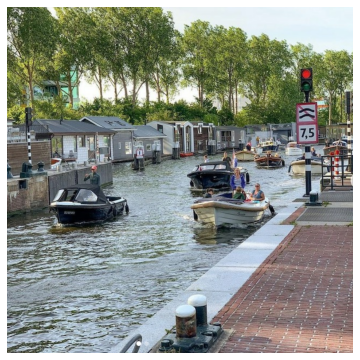

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

# Загрузим одно тестовое изображение
inference_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='inference', 
    image_size=(640, 640), 
    batch_size=1, 
    shuffle=False, 
    label_mode=None
)
# Преобразуем данные в формат numpy
inference_ds_numpy = list(inference_ds.as_numpy_iterator())

# Посмотрим изображение
plt.figure(figsize=(14, 14))
for i, image in enumerate(inference_ds_numpy):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image[0].astype("uint8"))
    plt.axis("off")
plt.show()

In [34]:
# Проведем детектирование
detections, predictions_dict, shapes = inference_detect_fn(inference_ds_numpy[0])

In [37]:
# Проверим размерность массивов, которые нам вернула функция
boxes = detections['detection_boxes'].numpy()
scores = detections['detection_scores'].numpy()
classes = detections['detection_classes'].numpy()
num_detections = detections['num_detections'].numpy()[0]

print('Количество обнаружений num_detections:', num_detections)
print('Размеры обнаружений boxes.shape: ', boxes.shape)
print('Рейтинги обнаружений scores.shape: ', scores.shape)
print('Ярлыки обнаружений classes.shape: ', classes.shape)

Количество обнаружений num_detections: 100.0
Размеры обнаружений boxes.shape:  (1, 100, 4)
Рейтинги обнаружений scores.shape:  (1, 100)
Ярлыки обнаружений classes.shape:  (1, 100)


Модель вернула нам 100 обнаружений

In [38]:
# Проверим первые 5 обнаружений
print('First 5 boxes:')
print(boxes[0,:5])

print('First 5 scores:')
print(scores[0,:5])

print('First 5 classes:')
print(classes[0,:5])

class_names = [coco_category_index[idx + 1]['name'] for idx in classes[0]]
print('First 5 class names:')
print(class_names[:5])

First 5 boxes:
[[0.17576031 0.8465482  0.25642633 0.8832797 ]
 [0.5187813  0.12410266 0.6344235  0.34545377]
 [0.5220359  0.5181462  0.6329132  0.7669856 ]
 [0.50933677 0.7045719  0.5619138  0.7446198 ]
 [0.44761643 0.51942706 0.6123767  0.75963426]]
First 5 scores:
[0.6950248  0.63430065 0.5911576  0.582722   0.5415638 ]
First 5 classes:
[9. 8. 8. 0. 8.]
First 5 class names:
['traffic light', 'boat', 'boat', 'person', 'boat']


In [39]:
# Импортируем вспомогательную функцию
from object_detection.utils import visualization_utils

# Создаем функцию для визуализации
def visualize_detections(image_np, detections, category_index):
  """
  Визуализирует ограничивающие рамки поверх изображения
  """
  label_id_offset = 1
  image_np_with_detections = image_np.copy()

  visualization_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.4,
      agnostic_mode=False,
  )

  plt.figure(figsize=(12, 16))
  plt.imshow(image_np_with_detections)
  plt.show()

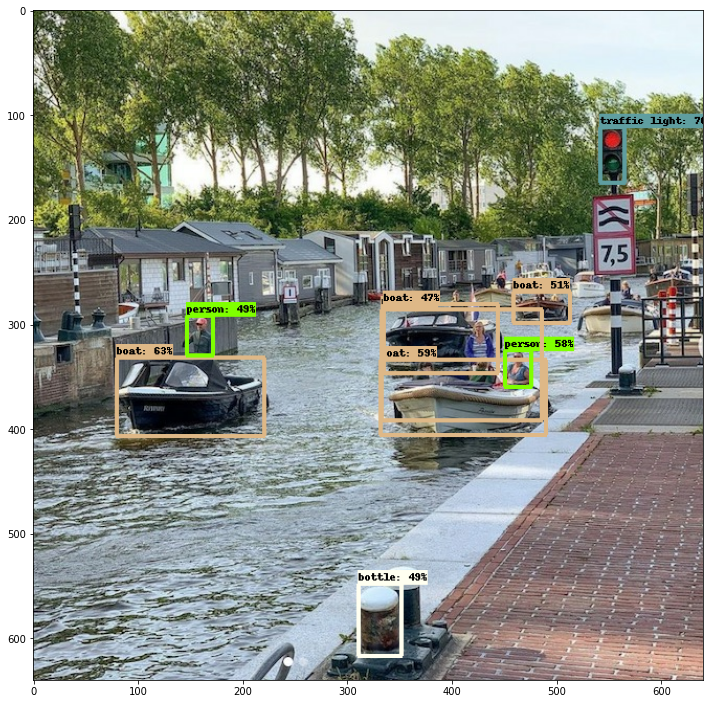

In [40]:
# Визуализируем обнаружения
visualize_detections(
    image_np=tf.cast(inference_ds_numpy[0][0], dtype=tf.uint32).numpy(),
    detections=detections,
    category_index=coco_category_index,
)